# 의사결정트리 분류 복잡도 최적화

## #01. 준비작업

### [1] 패키지 가져오기

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# 분석 알고리즘
from sklearn.tree import DecisionTreeClassifier, plot_tree

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### [2] 데이터 가져오기

In [3]:
origin = my_read_excel("https://data.hossam.kr/mldata/breast-cancer-wisconsin.xlsx", index_col="id", categories=["diagnosis"], info=False)

### [3] 전처리

스케일링 없이 `7:3` 비율로 데이터 분할

In [4]:
df1 = my_labelling(origin, 'diagnosis')
x_train, x_test, y_train, y_test = my_train_test_split(df1, 'diagnosis', test_size=0.3)

## #02. 기본 분류 모형

<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-------------+-------------------+
|    | criterion   |   mean_test_score |
|----+-------------+-------------------|
|  0 | gini        |          0.919525 |
|  1 | entropy     |          0.917025 |
+----+-------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |            1 |      0.94152 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |            1 |     0.939394 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |            1 |     0.911765 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |            0 |     0.038835 | 실제 음성

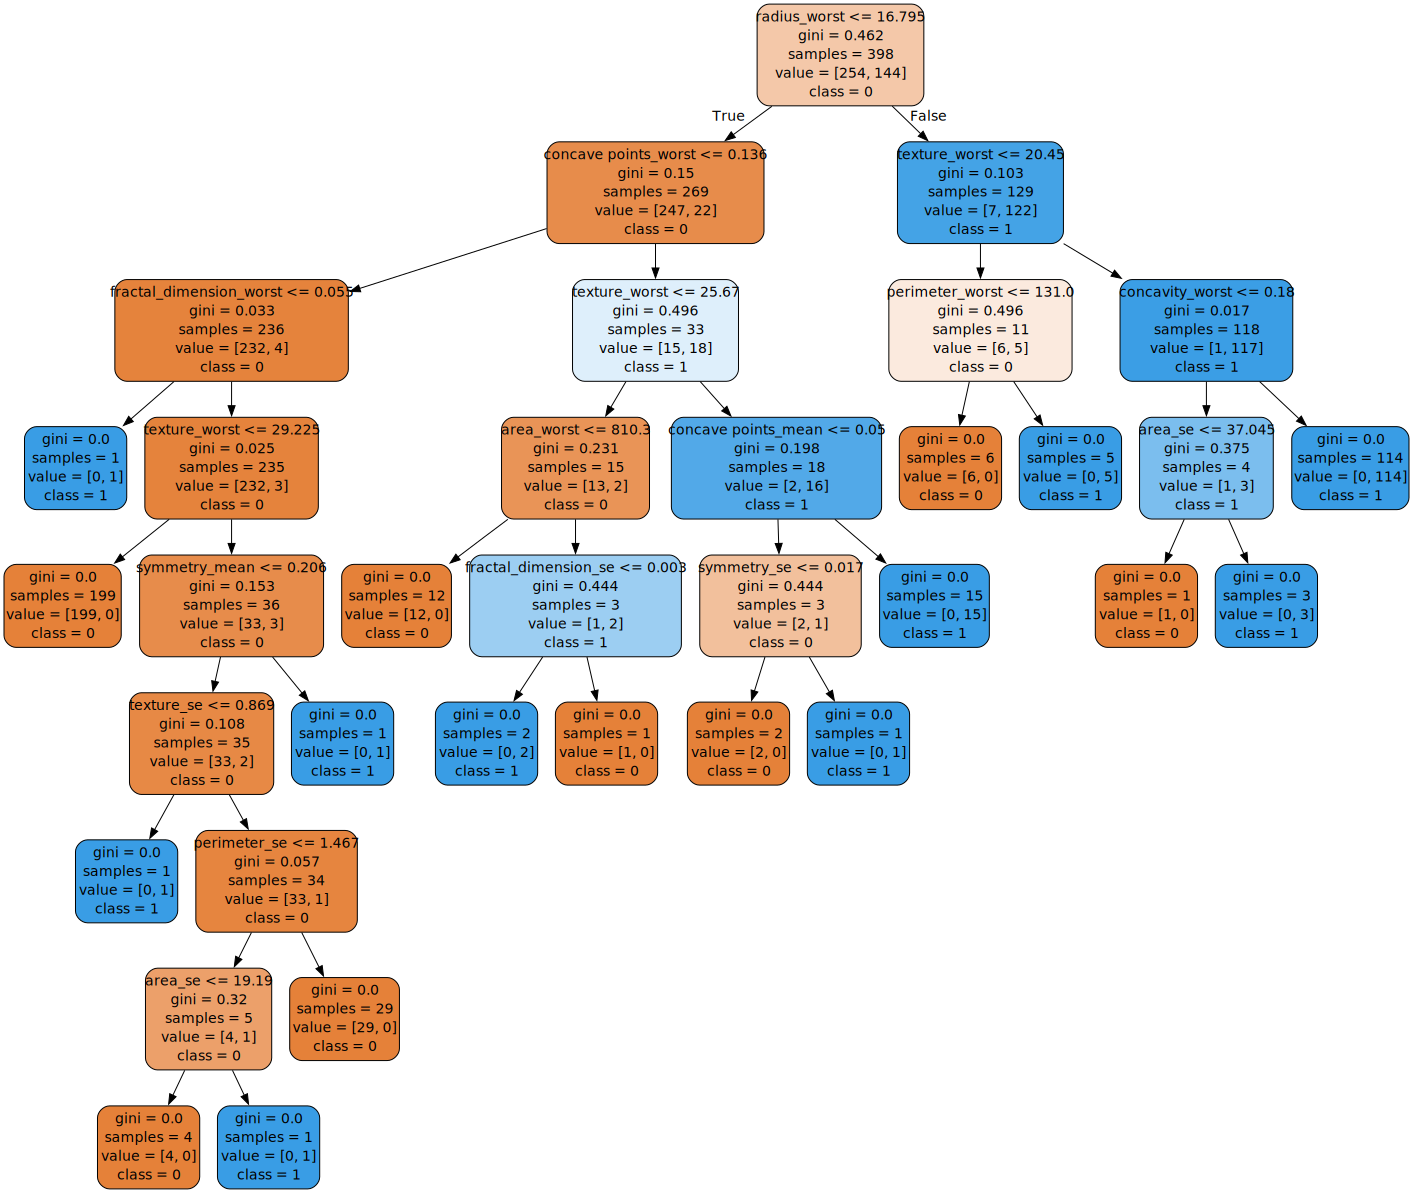

In [5]:
cv_estimator = my_dtree_classification(x_train, y_train, x_test, y_test, hist=False, roc=False, pr=False, conf_matrix=False, learning_curve=False)

## #03. Pruning (가지치기)

dtree 분류기 객체의 `cost_complexity_pruning_path()`메서드는 각 과정마다 효과적인 불순도와 이를 위한 알파값을 반환한다.

### [1] 알파값, 불순도 구하기

In [7]:
dtree = DecisionTreeClassifier(random_state=1234)
path = dtree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas, impurities)

[0.         0.00243866 0.00249127 0.0033352  0.00335008 0.00335008
 0.00487689 0.00536013 0.00558347 0.01370489 0.01457968 0.02347089
 0.04063679 0.32702814] [0.         0.00487733 0.00985987 0.01986547 0.02321555 0.02656563
 0.03144252 0.03680266 0.04238613 0.05609102 0.0706707  0.09414159
 0.13477838 0.46180652]


### [2] 알파값, 불순도 시각화

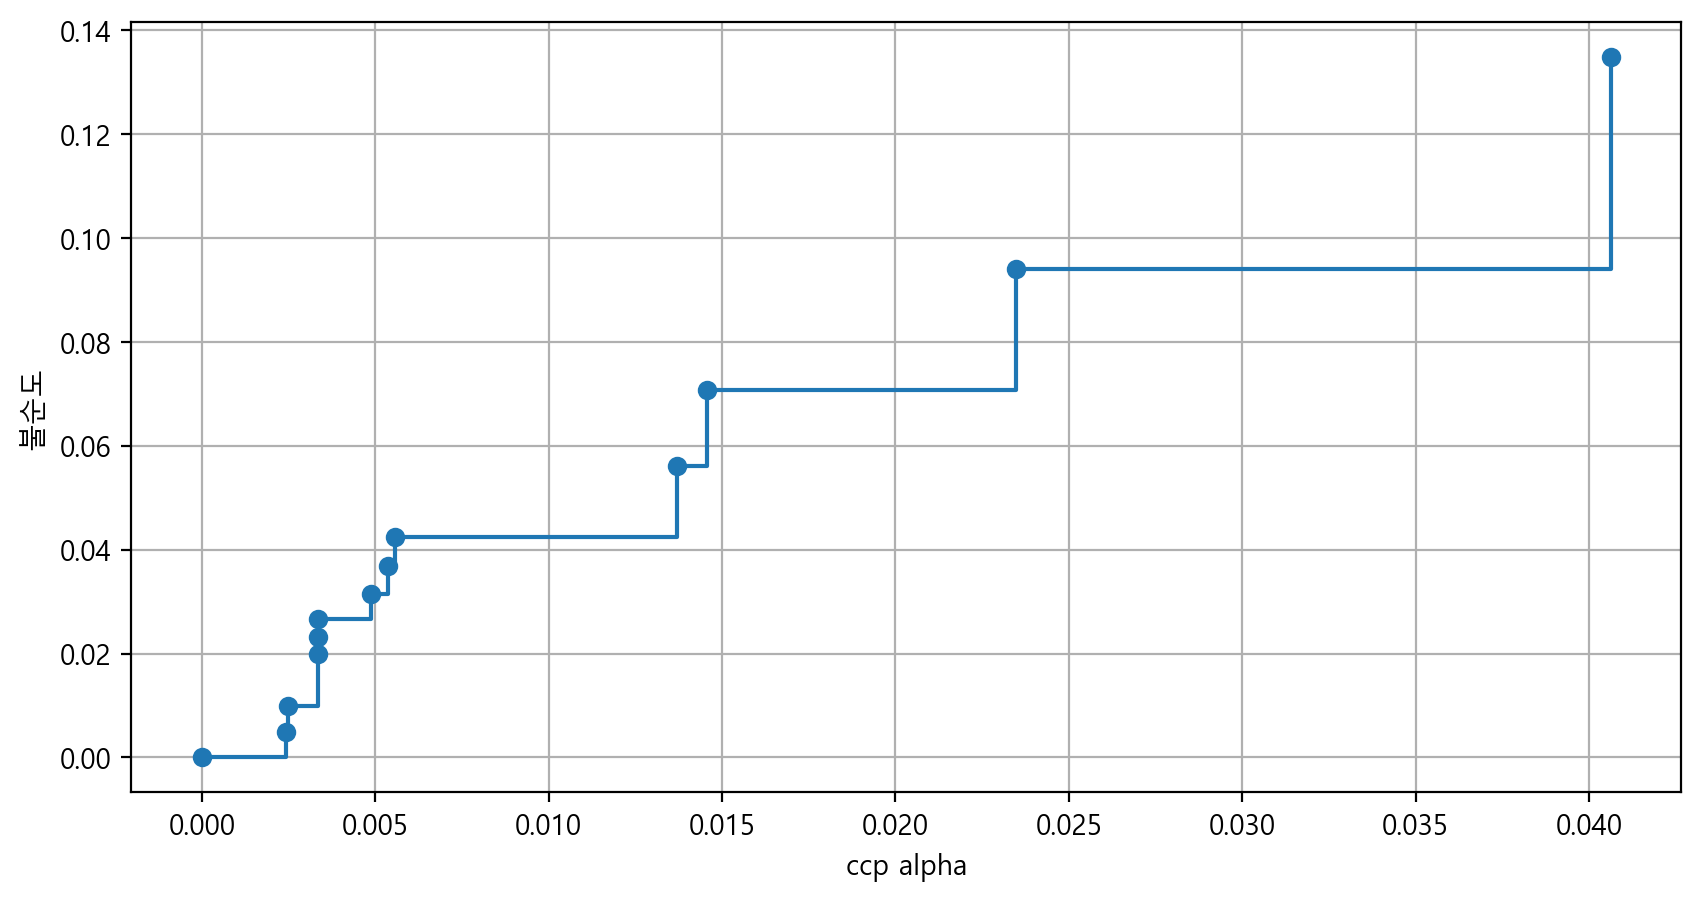

In [9]:
fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.gca()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("ccp alpha")
ax.set_ylabel("불순도")
ax.grid()
plt.show()
plt.close()

> 알파값이 커질 수록 불순도가 높아진다. 그러므로 최적의 정확도와 가장 낮은 알파값을 동시에 충족하는 모형을 찾아야 한다.

### [3] 알파값을 적용한 DTree 객체 생성후 노드의 수 확인

In [11]:
# 의미 없는 양 끝의 값을 제외하고 알파값 목록을 생성
ccp_alphas = ccp_alphas[1:-1]
estimator_list = []

for ccp_alpha in ccp_alphas:
    dtree = DecisionTreeClassifier(random_state=1234, ccp_alpha=ccp_alpha)
    dtree.fit(x_train, y_train)

    # 분류기 객체를 리스트에 담는다.
    estimator_list.append(dtree)

# 각 분류기에 따른 트리의 노드 수 확인
t_nodes = [e.tree_.node_count for e in estimator_list]
t_nodes

[27, 21, 17, 17, 15, 13, 11, 9, 7, 5]

> 알파값에 의해 노드 수가 점차 줄어들고 있다. 노드 수가 지나치게 작을 경우 정확도는 분명 떨어질 것이다.

### [4] 알파값에 따른 의사결정트리 비교

[node_size: 27, ccp_alpha: 0.0025] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |      0.94152 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.939394 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.911765 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.038835 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.961165 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.925373 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.920617 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+------------------------

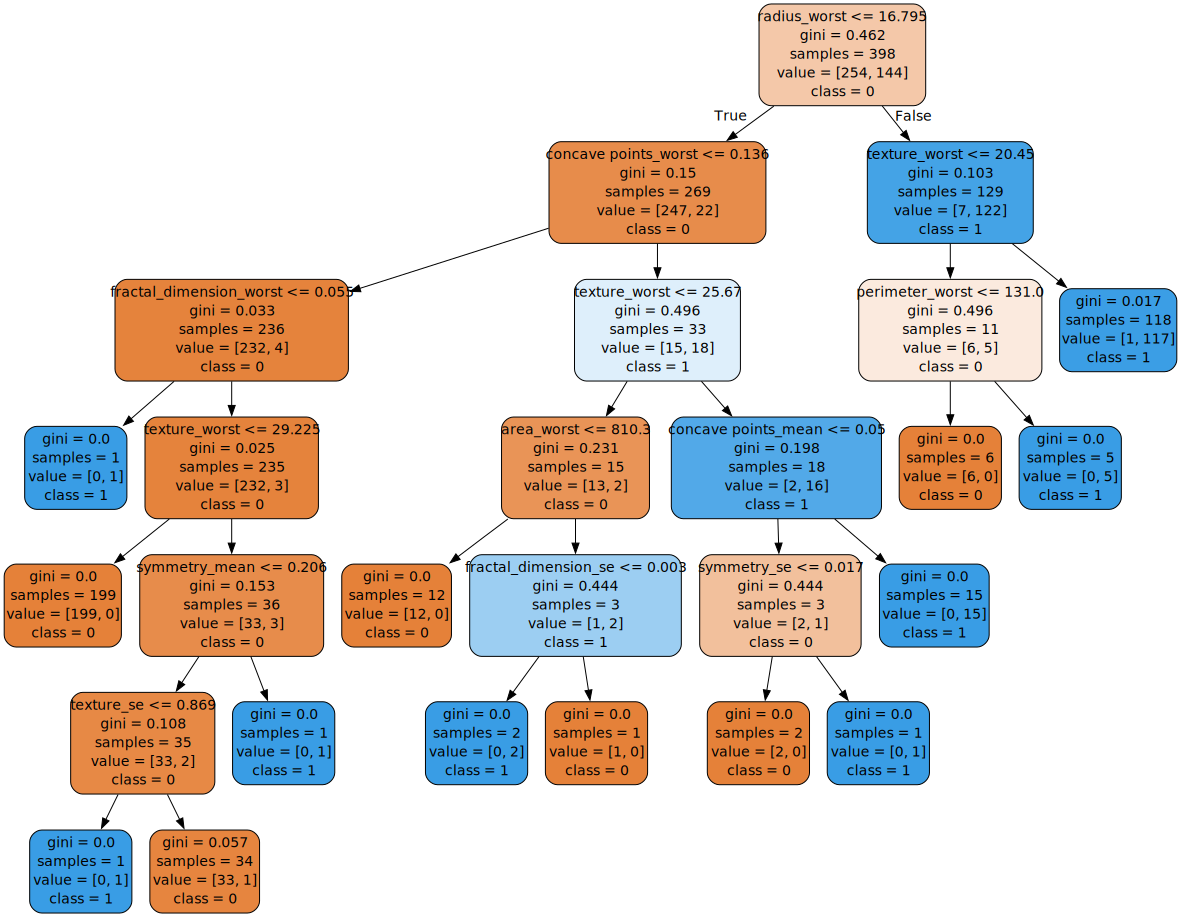












[node_size: 21, ccp_alpha: 0.0033] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.953216 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |      0.96875 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.911765 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0194175 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.980583 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.939394 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.909123 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+-------------

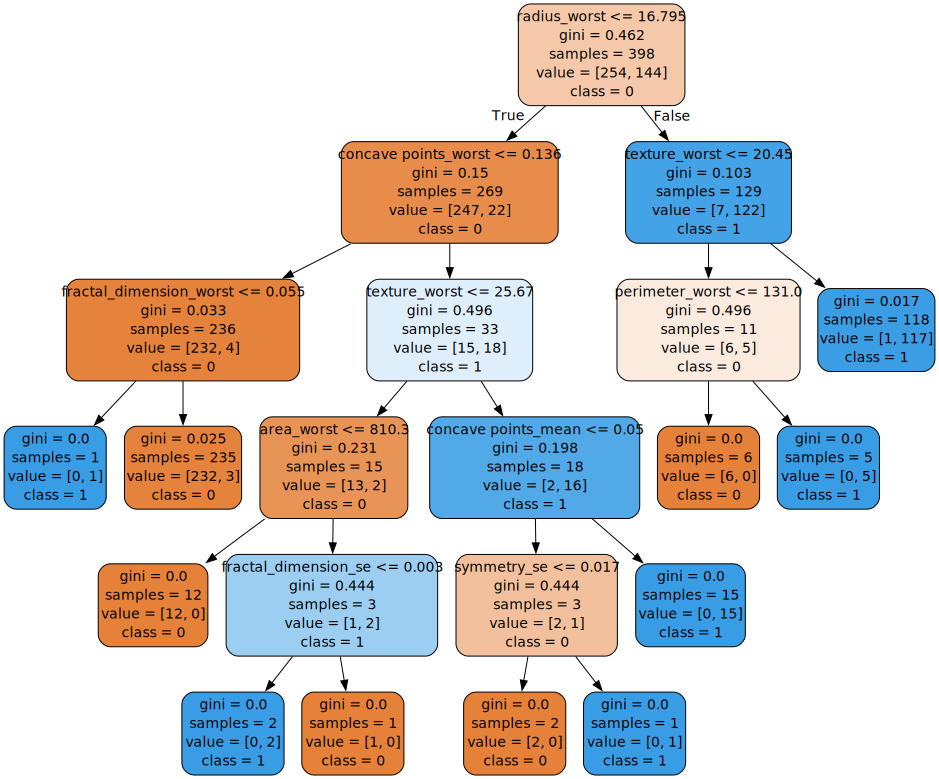












[node_size: 17, ccp_alpha: 0.0034] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.959064 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.969231 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.926471 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0194175 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.980583 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.947368 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.923187 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+-------------

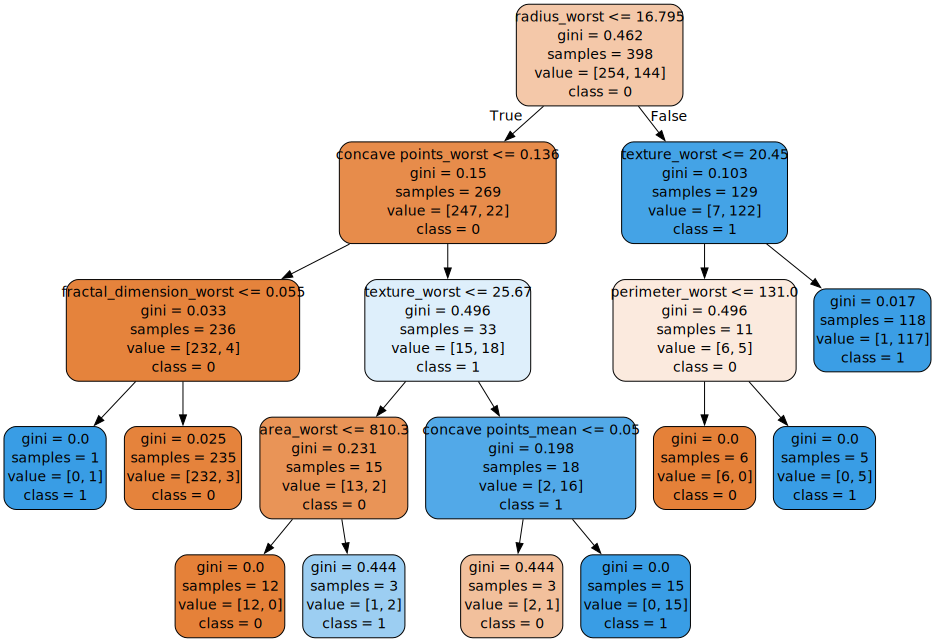












[node_size: 17, ccp_alpha: 0.0034] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.959064 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.969231 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.926471 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0194175 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.980583 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.947368 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.923187 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+-------------

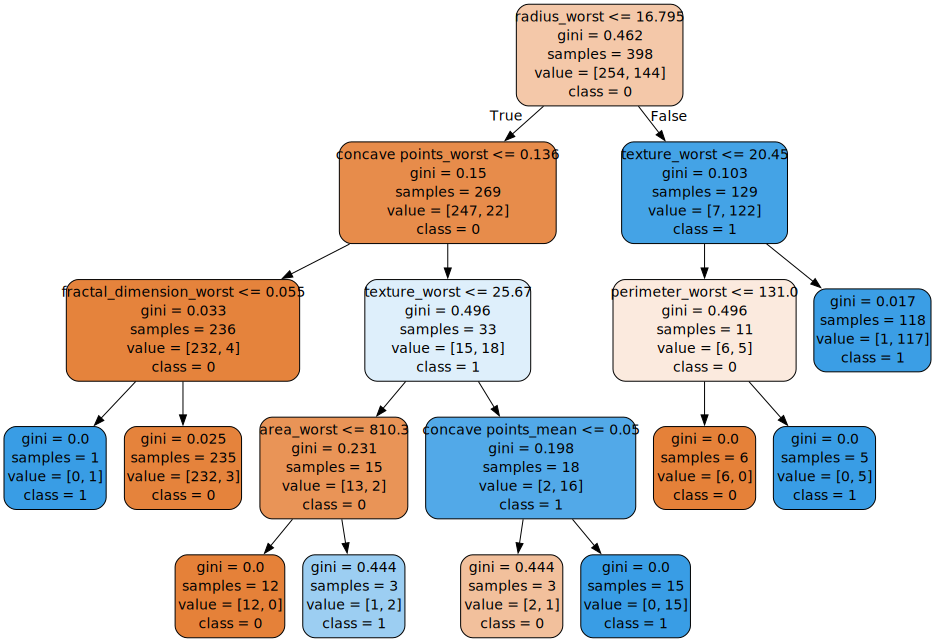












[node_size: 15, ccp_alpha: 0.0049] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.959064 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.969231 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.926471 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0194175 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.980583 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.947368 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.923187 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+-------------

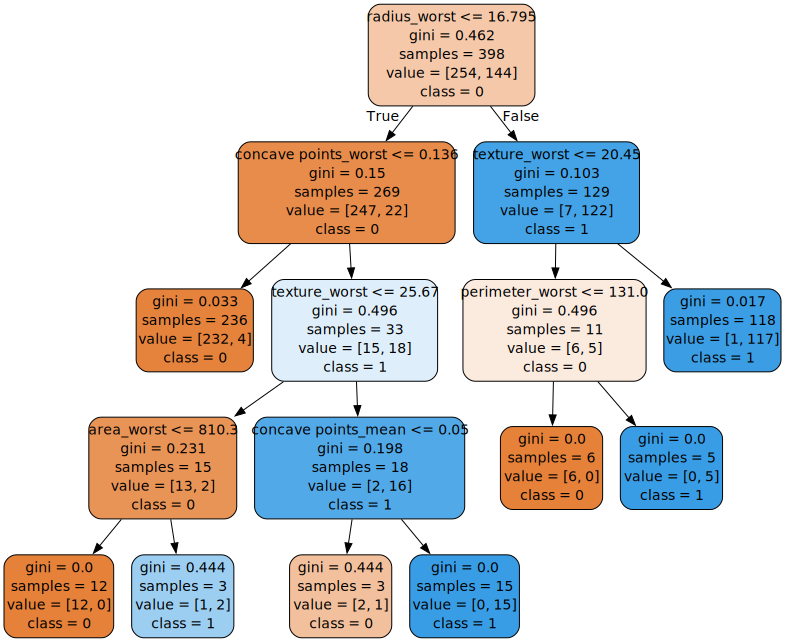












[node_size: 13, ccp_alpha: 0.0054] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.953216 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |      0.96875 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.911765 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0194175 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.980583 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.939394 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.936251 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+-------------

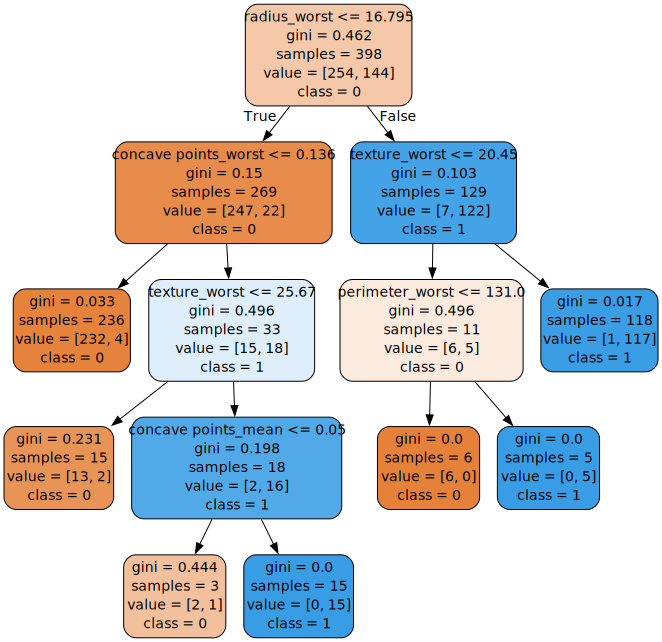












[node_size: 11, ccp_alpha: 0.0056] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.953216 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |      0.96875 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.911765 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0194175 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.980583 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.939394 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.942747 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+-------------

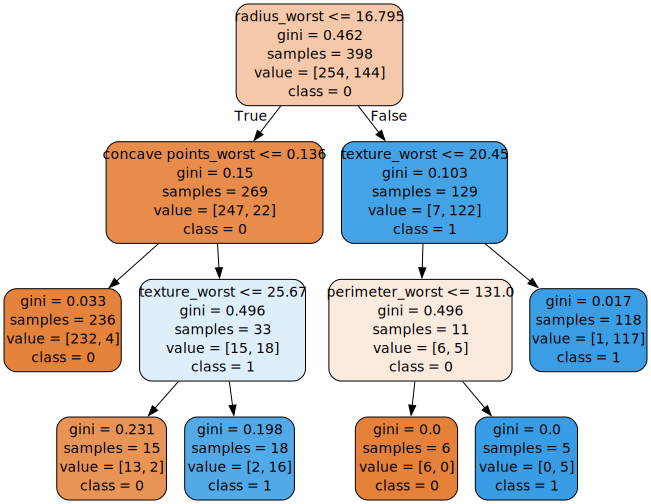












[node_size: 9, ccp_alpha: 0.0137] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.947368 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.968254 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.897059 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0194175 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.980583 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.931298 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.982938 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+--------------

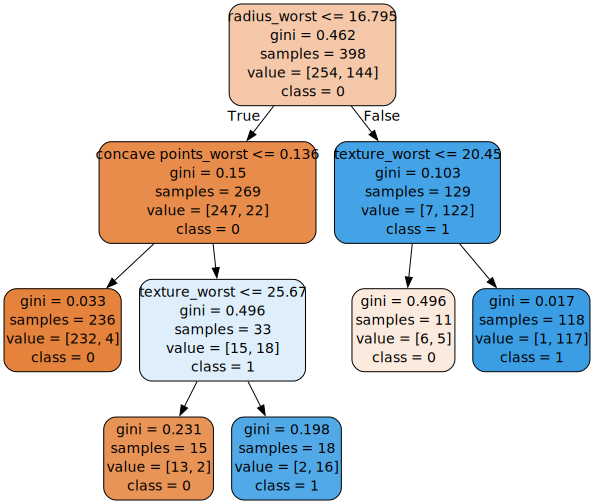












[node_size: 7, ccp_alpha: 0.0146] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.953216 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.928571 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.955882 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0485437 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.951456 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.942029 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.969018 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+--------------

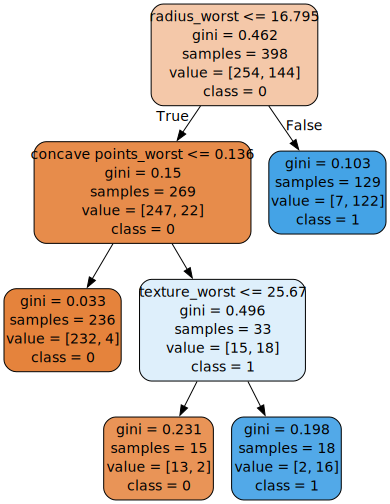












[node_size: 5, ccp_alpha: 0.0235] ================================================== 

[분류분석 성능평가]
+-------------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 | 설명                                                      |
|-------------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.953216 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.905405 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.985294 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0679612 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.932039 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.943662 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.968018 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+-------------------+--------------+--------------

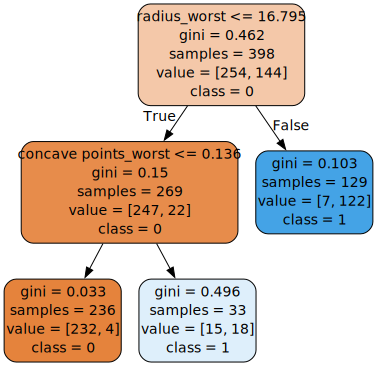

In [12]:
for i, v in enumerate(estimator_list):
    print("[node_size: {0}, ccp_alpha: {1:.4f}]".format(v.tree_.node_count, ccp_alphas[i]), "="*50, "\n")
    my_classification_result(v, x_test, y_test, hist=False, roc=False, pr=False, conf_matrix=False, learning_curve=False)
    print("\n" * 10)

### [5] 알파값에 따른 성능 변화

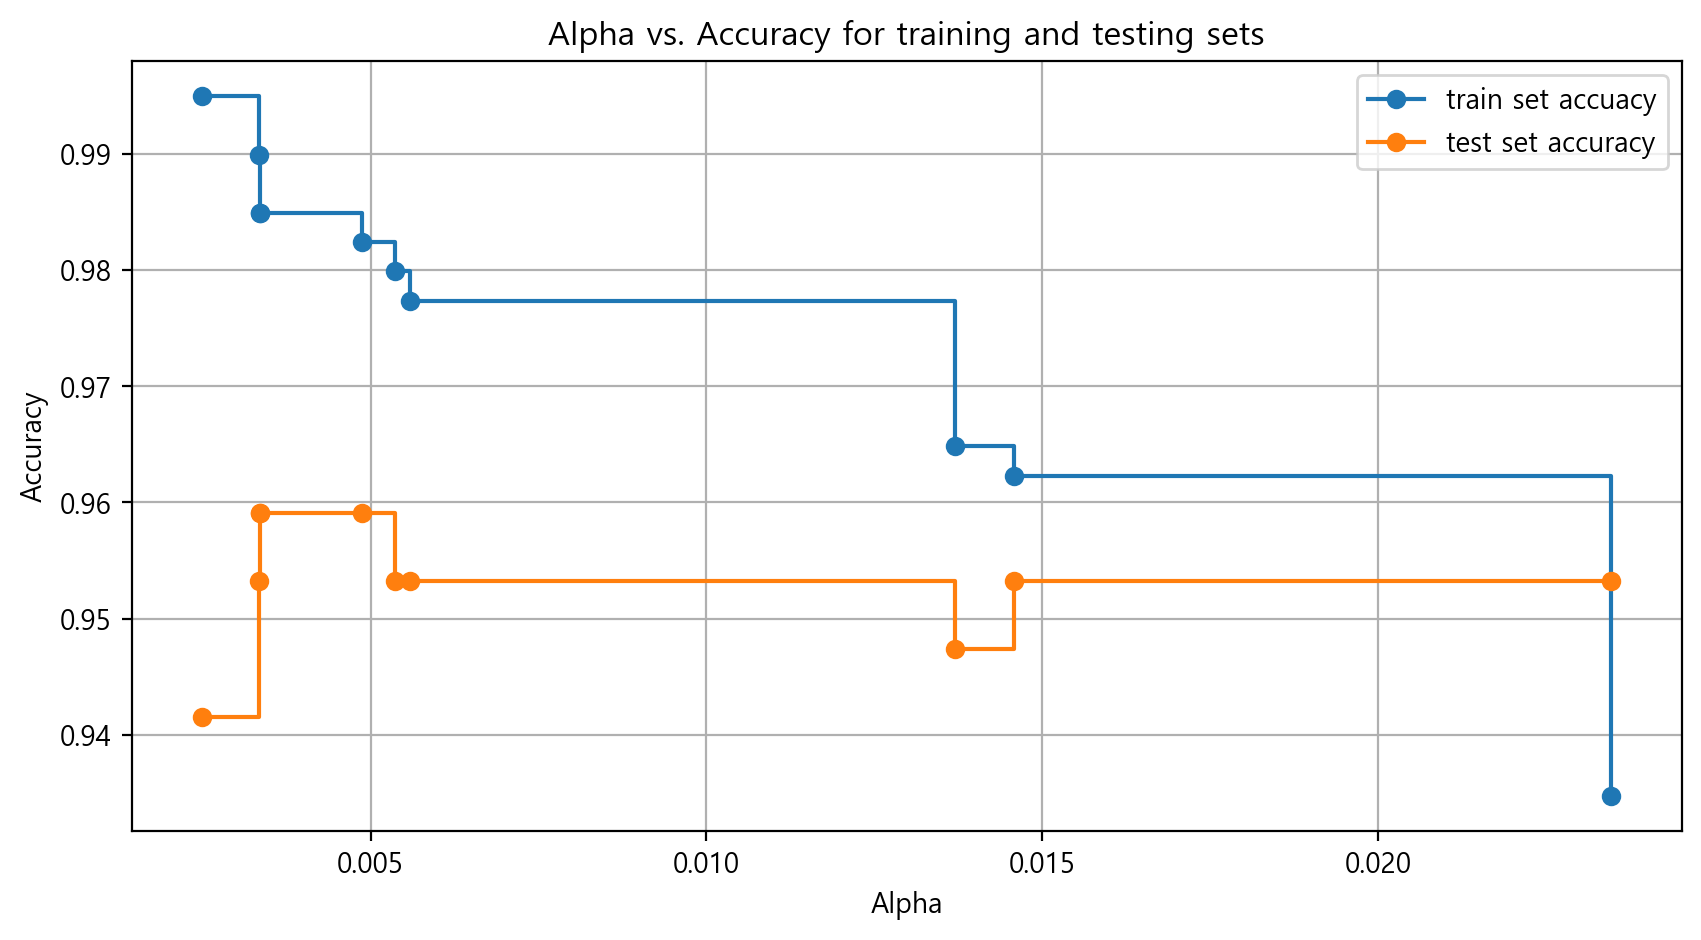

In [13]:
train_scores = []
test_scores = []

for v in estimator_list:
    train_scores.append(v.score(x_train, y_train))
    test_scores.append(v.score(x_test, y_test))

fig = plt.figure(figsize=(10, 5), dpi=200)
ax = fig.gca()
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Alpha vs. Accuracy for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train set accuacy", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test set accuracy", drawstyle="steps-post")
ax.legend()
ax.grid()
plt.show()
plt.close()

### [6] 검증데이터에 대한 스코어에 따른 알파값

In [16]:
df = DataFrame({"test acc": test_scores, "alpha":ccp_alphas})
df.sort_values(["test acc", "alpha"], ascending=[False, True], inplace=True)
df.reset_index(drop=True, inplace=True)
my_pretty_table(df)

+----+------------+------------+
|    |   test acc |      alpha |
|----+------------+------------|
|  0 |   0.959064 | 0.00335008 |
|  1 |   0.959064 | 0.00335008 |
|  2 |   0.959064 | 0.00487689 |
|  3 |   0.953216 |  0.0033352 |
|  4 |   0.953216 | 0.00536013 |
|  5 |   0.953216 | 0.00558347 |
|  6 |   0.953216 |  0.0145797 |
|  7 |   0.953216 |  0.0234709 |
|  8 |   0.947368 |  0.0137049 |
|  9 |    0.94152 | 0.00249127 |
+----+------------+------------+


In [17]:
"최적의 알파값:", df['alpha'][0]

('최적의 알파값:', 0.003350083752093802)

### [7] 알파값을 적용한 새로운 분석 모형

depth: 4 leaves: 9


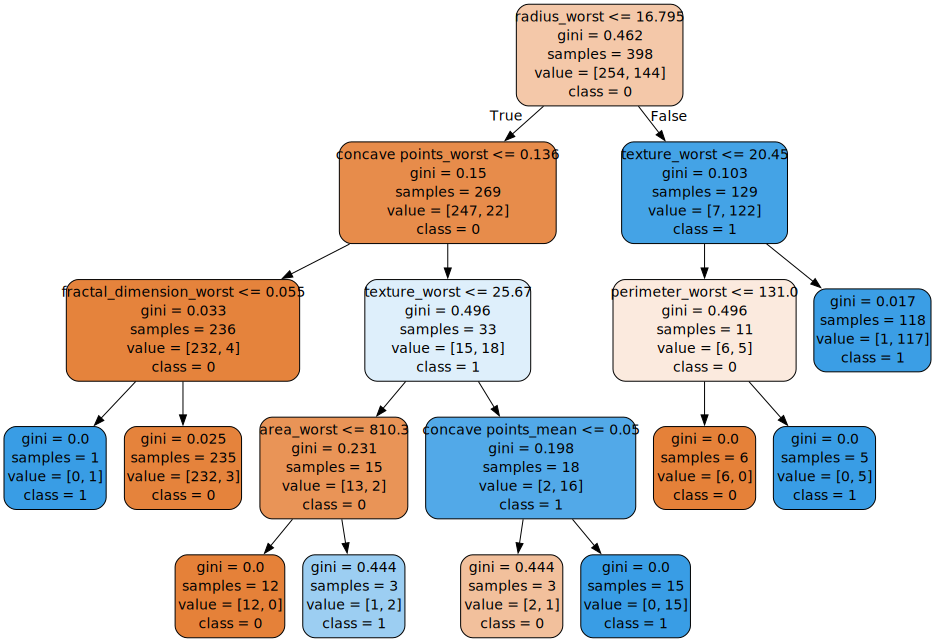

In [20]:
final_estimator = DecisionTreeClassifier(criterion='gini', random_state=1234, ccp_alpha=df['alpha'][0])
final_estimator.fit(x_train, y_train)
my_tree(final_estimator)

### [8] 알파값 리스트를 적용한 RandomizeSearhCV 기능 확인

> 모듈화 내용

<class 'sklearn.tree._classes.DecisionTreeClassifier'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-------------+-------------+-------------------+
|    | criterion   |   ccp_alpha |   mean_test_score |
|----+-------------+-------------+-------------------|
| 18 | gini        |   0.0145797 |           0.94212 |
| 16 | gini        |   0.0137049 |           0.94212 |
| 23 | entropy     |   0.0406368 |          0.942089 |
| 21 | entropy     |   0.0234709 |          0.942089 |
| 19 | entropy     |   0.0145797 |          0.932025 |
+----+-------------+-------------+-------------------+

[Best Params]
{'criterion': 'gini', 'ccp_alpha': 0.013704888076747374}

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accura

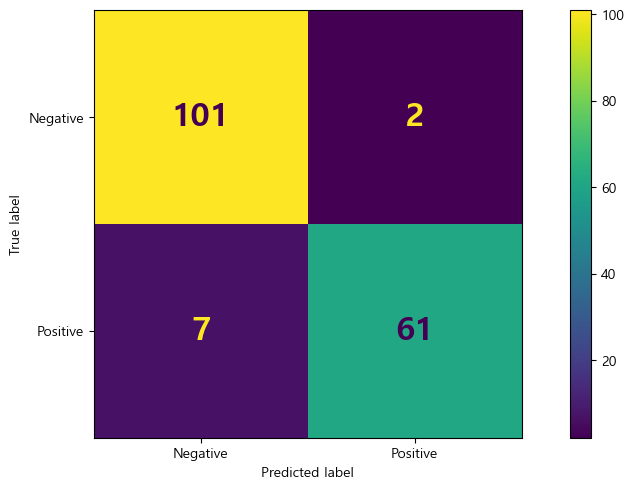

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


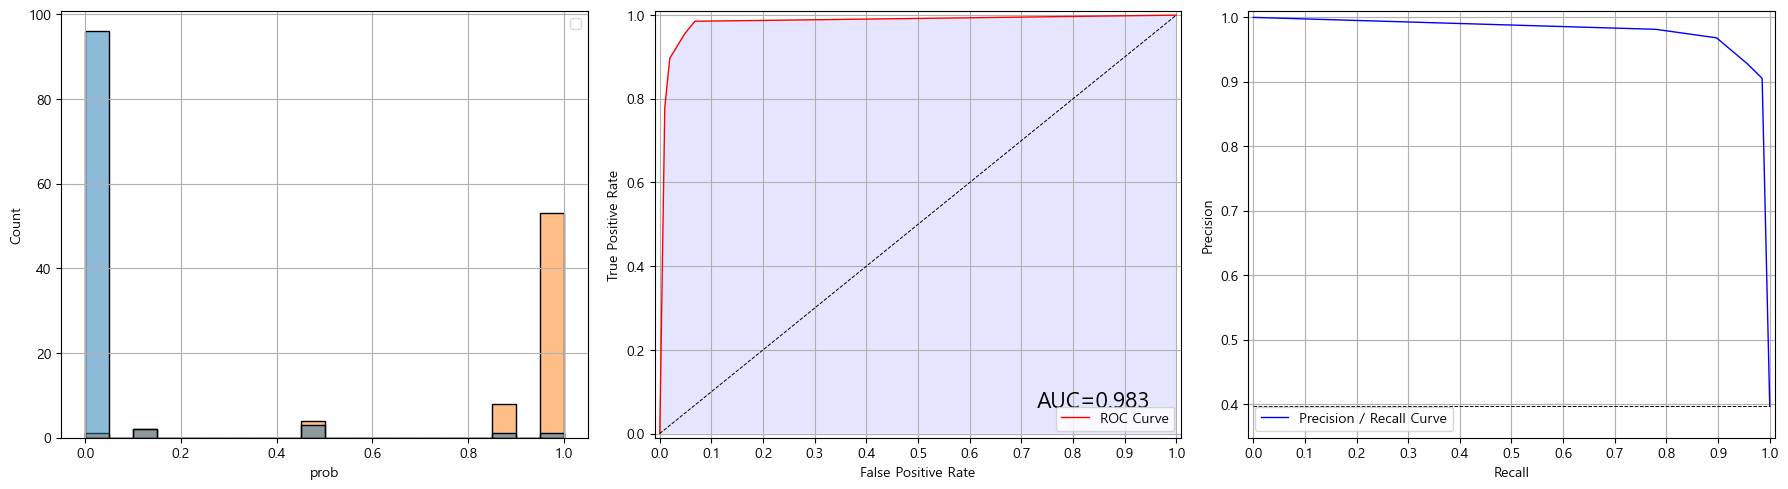


[학습곡선]


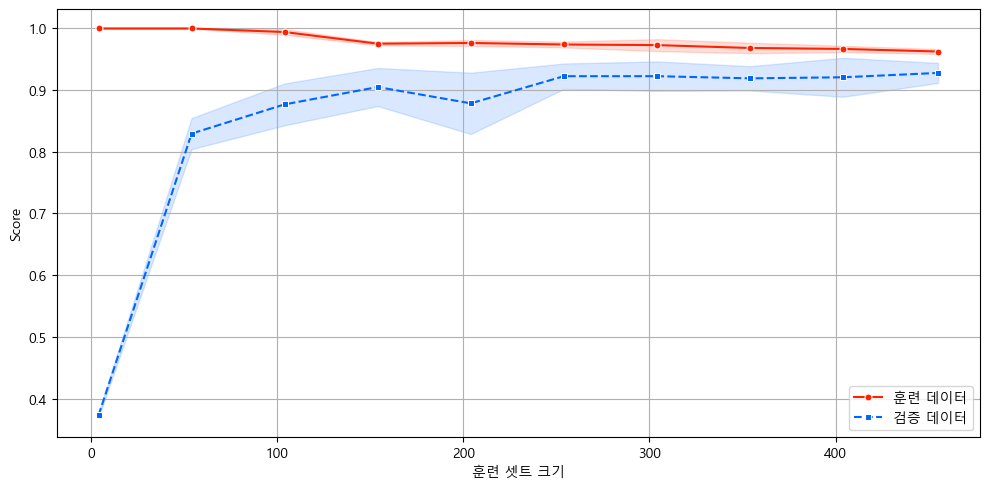

depth: 3 leaves: 5


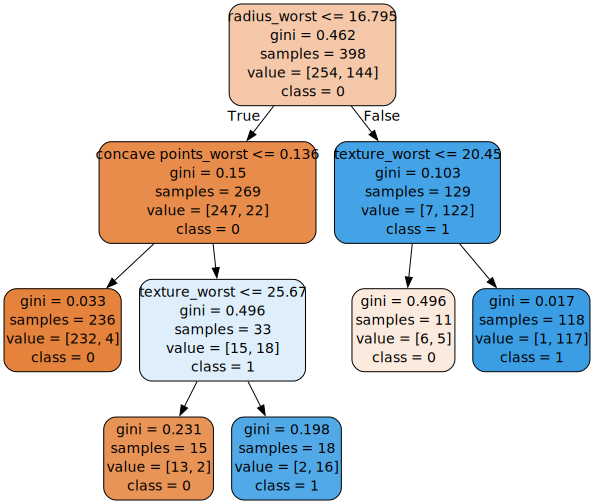

DecisionTreeClassifier(ccp_alpha=0.013704888076747374, random_state=1234)

In [24]:
my_dtree_classification(x_train, y_train, x_test, y_test)